Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [5]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings(
#     "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
# )
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


In [6]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS


## Parameters


In [7]:
# params
max_epochs = 3
device = "cuda:0"

cfg = ExtractConfig(
    max_examples=(1000, 1000),
    # model="wassname/phi-1_5-w_hidden_states",
    # batch_size=3,
    # model="wassname/phi-2-w_hidden_states",
    model="microsoft/phi-2",
    # model="microsoft/phi-1_5",
    # model="Walmart-the-bag/phi-2-uncensored",
    batch_size=1,
    prompt_format="phi",
)


## Load model

In [8]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
    trust_remote_code=True,
    # model_class=PhiForCausalLMWHS, # ti add hidden states
    # bnb=False,
)
# model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# for normal seetings see https://github.com/huggingface/peft/blob/cf04d0353f0343cbf66627228c4495f51669af34/src/peft/utils/constants.py#L81
# and https://github.com/huggingface/peft/blob/cf04d0353f0343cbf66627228c4495f51669af34/src/peft/utils/constants.py#L102
# "llama": ["k_proj", "v_proj", "down_proj"],
# "gptj": ["q_proj", "v_proj", "fc_out"],
# "falcon": ["query_key_value", "dense_4h_to_h"],

# for activation gathering
# note ia3 would usually be on fc2, but it would be set as feedforward, meaning it's on the inputs to fc2
# but to make collection easier we do everything on the outputs. So we use the outputs of the previous layer (fc1) instead of the inputs of fc2
peft_config = IA3Config(
    # task_type=TaskType.SEQ_CLS, 
    task_type=TaskType.CAUSAL_LM,
    target_modules=[ "fc1",  "Wqkv",], 
        feedforward_modules=[],
        inference_mode=False,
)
# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, es=[ "fc1", "fc2", "Wqkv","out_proj"], 
#         feedforward_modules=["fc2","out_proj", "fc1"]
# )

# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[  "fc2", "out_proj"], 
#         feedforward_modules=[]
# )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 573,440 || all params: 2,780,257,280 || trainable%: 0.020625429312786478


In [10]:
# FIXME, find the layer names using the IA3 config
import itertools
module_names = [key for key, _ in model.named_modules()]
collection_layers = []
for pattern in peft_config.target_modules:
    collection_layers.extend([key for key in module_names if key.endswith(pattern)])
collection_layers = sorted(collection_layers)
collection_layers
                           

# see also how peft does regexp to layers https://github.dev/huggingface/peft/blob/cf04d0353f0343cbf66627228c4495f51669af34/src/peft/tuners/tuners_utils.py#L205
# target_name_key = next(filter(lambda key: re.match(f"(.*\.)?{key}$", current_key), pattern_keys), target_name)


# collection_layers = cfg.collection_layers
# target_module_found = any(key.endswith(target_key) for target_key in model.modules_to_save)


['base_model.model.transformer.h.0.mixer.Wqkv',
 'base_model.model.transformer.h.0.mlp.fc1',
 'base_model.model.transformer.h.1.mixer.Wqkv',
 'base_model.model.transformer.h.1.mlp.fc1',
 'base_model.model.transformer.h.10.mixer.Wqkv',
 'base_model.model.transformer.h.10.mlp.fc1',
 'base_model.model.transformer.h.11.mixer.Wqkv',
 'base_model.model.transformer.h.11.mlp.fc1',
 'base_model.model.transformer.h.12.mixer.Wqkv',
 'base_model.model.transformer.h.12.mlp.fc1',
 'base_model.model.transformer.h.13.mixer.Wqkv',
 'base_model.model.transformer.h.13.mlp.fc1',
 'base_model.model.transformer.h.14.mixer.Wqkv',
 'base_model.model.transformer.h.14.mlp.fc1',
 'base_model.model.transformer.h.15.mixer.Wqkv',
 'base_model.model.transformer.h.15.mlp.fc1',
 'base_model.model.transformer.h.16.mixer.Wqkv',
 'base_model.model.transformer.h.16.mlp.fc1',
 'base_model.model.transformer.h.17.mixer.Wqkv',
 'base_model.model.transformer.h.17.mlp.fc1',
 'base_model.model.transformer.h.18.mixer.Wqkv',
 'bas

In [11]:
model


PeftModelForCausalLM(
  (base_model): IA3Model(
    (model): PhiForCausalLM(
      (transformer): PhiModel(
        (embd): Embedding(
          (wte): Embedding(51200, 2560)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (h): ModuleList(
          (0-31): 32 x ParallelBlock(
            (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (resid_dropout): Dropout(p=0.1, inplace=False)
            (mixer): MHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): ia3.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 7680x1 (cuda:0)])
              )
              (out_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
              (inner_attn): SelfAttention(
                (drop): Dropout(p=0.0, inplace=False)
              )
              (inner_cross_attn): C

## Load datasets

In [12]:
assert len(set(cfg.datasets).intersection(cfg.datasets_ood))==0, "datasets overlap"


In [13]:
N = sum(cfg.max_examples)
ds_tokens = load_preproc_datasets(
    cfg.datasets,
    tokenizer,
    N=N,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens


2024-01-01 07:34:36.863 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:359 - setting tokenizer chat template to phi
2024-01-01T07:34:36.863023+0800 INFO setting tokenizer chat template to phi
2024-01-01 07:34:37.115 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 398.0 for amazon_polarity. max_length=776
2024-01-01T07:34:37.115369+0800 INFO median token length: 398.0 for amazon_polarity. max_length=776
2024-01-01 07:34:37.122 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 0.00% on amazon_polarity
2024-01-01T07:34:37.122066+0800 INFO truncation rate: 0.00% on amazon_polarity
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 2005
})

In [14]:
ds_tokens2 = load_preproc_datasets(
    cfg.datasets_ood,
    tokenizer,
    N=N // 2,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens2


prompt_truncated:   0%|          | 0/1004 [00:00<?, ? examples/s]

choice_ids:   0%|          | 0/1004 [00:00<?, ? examples/s]

2024-01-01 07:34:40.462 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 484.0 for super_glue:boolq. max_length=776
2024-01-01T07:34:40.462715+0800 INFO median token length: 484.0 for super_glue:boolq. max_length=776
2024-01-01 07:34:40.463 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 2.49% on super_glue:boolq
2024-01-01T07:34:40.463749+0800 INFO truncation rate: 2.49% on super_glue:boolq


Filter:   0%|          | 0/1004 [00:00<?, ? examples/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter:   0%|          | 0/979 [00:00<?, ? examples/s]

2024-01-01 07:34:41.305 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:403 - num_rows (after filtering out truncated rows) 1004=>979
2024-01-01T07:34:41.305602+0800 INFO num_rows (after filtering out truncated rows) 1004=>979


format_prompt:   0%|          | 0/712 [00:00<?, ? examples/s]

tokenize:   0%|          | 0/712 [00:00<?, ? examples/s]

truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

prompt_truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

choice_ids:   0%|          | 0/712 [00:00<?, ? examples/s]

2024-01-01 07:34:43.748 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 167.5 for super_glue:axg. max_length=776
2024-01-01T07:34:43.748537+0800 INFO median token length: 167.5 for super_glue:axg. max_length=776
2024-01-01 07:34:43.749 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 0.00% on super_glue:axg
2024-01-01T07:34:43.749432+0800 INFO truncation rate: 0.00% on super_glue:axg


Filter:   0%|          | 0/712 [00:00<?, ? examples/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter:   0%|          | 0/712 [00:00<?, ? examples/s]

2024-01-01 07:34:44.367 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:403 - num_rows (after filtering out truncated rows) 712=>712
2024-01-01T07:34:44.367312+0800 INFO num_rows (after filtering out truncated rows) 712=>712
2024-01-01 07:34:44.437 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 776.0 for imdb. max_length=776
2024-01-01T07:34:44.437757+0800 INFO median token length: 776.0 for imdb. max_length=776
2024-01-01 07:34:44.438 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 63.35% on imdb
2024-01-01T07:34:44.438891+0800 INFO truncation rate: 63.35% on imdb
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detec

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 1002
})

## custom models

In [15]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select

class AtapterFinetunerLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        simply train it to lie
        """
        device = out.logits.device

        log_probs_a = torch.log_softmax(out_a["logits"][:, -1,], -1,)

        # batch['instructed_to_lie']
        lie_label = ~batch['label_true']
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long()).to(device)
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long()).to(device)
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [16]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select


class AtapterFinetunerToldToLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        train it to lie when instructed
        """
        device = out.logits.device

        end_logits = out_a["logits"][
            :,
            -1,
        ]
        log_probs_a = torch.log_softmax(end_logits, -1)

        lie_label = batch["label_true"] ^ batch["instructed_to_lie"]
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long()).to(device)
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long()).to(device)
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [17]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select


class AtapterFinetunerTruth(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        train it to lie when instructed
        """
        device = out.logits.device

        end_logits = out_a["logits"][
            :,
            -1,
        ]
        log_probs_a = torch.log_softmax(end_logits, -1)

        lie_label = batch["label_true"] #^ batch["instructed_to_lie"]
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long()).to(device)
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long()).to(device)
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [18]:
model_cls = AtapterFinetunerToldToLie


## Train

In [19]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
len(dl_train), len(dl_val)


(1002, 501)

In [20]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([1, 776])


776

In [21]:
net = model_cls(
    model, tokenizer, lr=4e-3, weight_decay=0, total_steps=len(dl_train) * max_epochs, collection_layers=collection_layers
)

print(c_in)


776


In [18]:
# # debug
# # net.half()
# with torch.no_grad():
#     o = net.training_step(b, None)
# o


In [19]:
# # debug
# with torch.no_grad():
#     o = net.predict_step(b, None)
# o.keys()


In [20]:


trainer = pl.Trainer(
    precision='16-mixed',

    # gradient_clip_val=20,
    devices="1",
    accelerator="gpu",
    accumulate_grad_batches=8,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    # plugins=precision,
    # enable_model_summary=False,
)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | PeftModelForCausalLM | 1.5 B 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [21]:
checkpoint_path = Path(trainer.log_dir) / "checkpoint_last"
model.save_pretrained(checkpoint_path)
checkpoint_path


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_1/checkpoint_last')

In [22]:
# save config
f = Path(trainer.log_dir) / 'config.yaml'
cfg.save_yaml(f)
f


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_1/config.yaml')

## Hist

In [23]:
# suffixes = list(set([c.split('/')[-1] for c in df_hist.columns if '/' in c]))
# for suffix in suffixes:
#     print(suffix)
#     df_hist[[c for c in df_hist.columns if c.endswith(suffix) and '/' in c]].plot(title=suffix, style='.')
#     plt.title(suffix)
# plt.show()
# df_hist


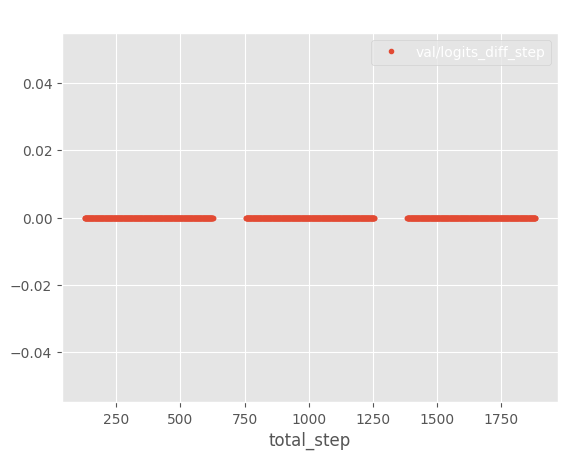

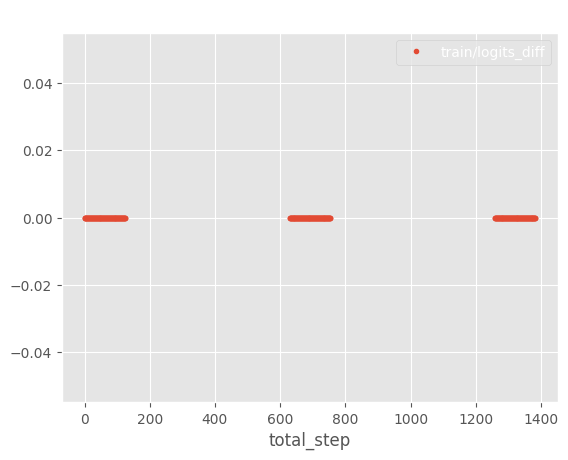

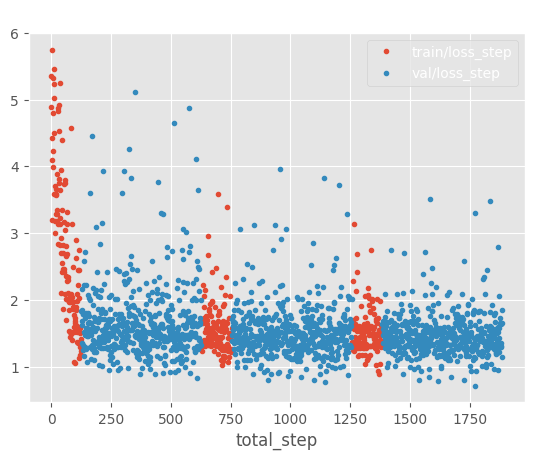

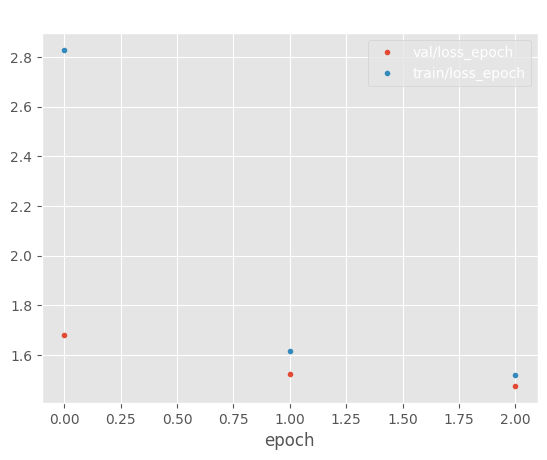

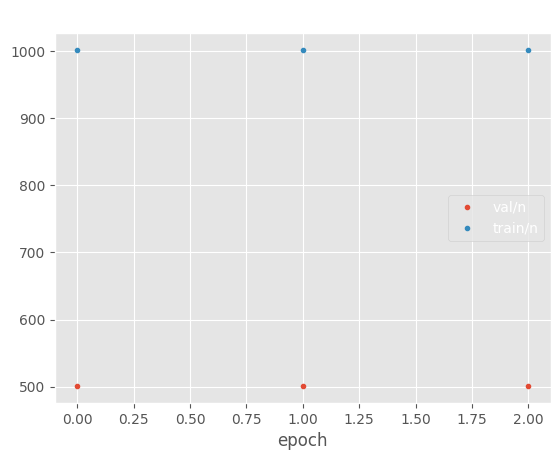

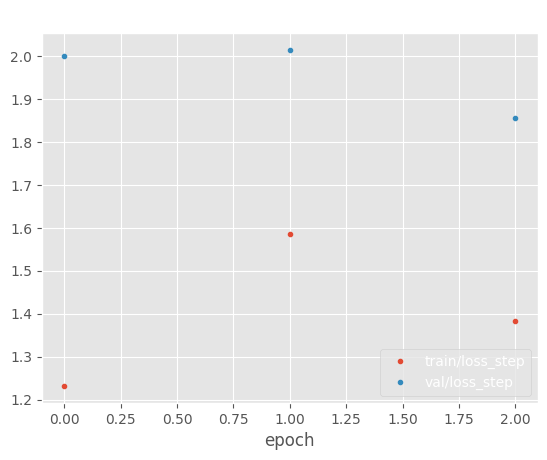

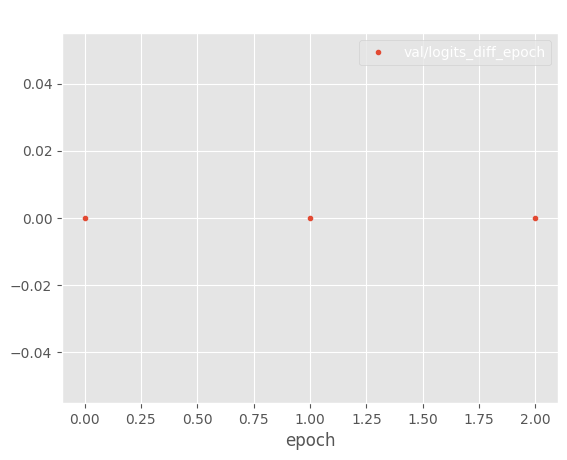

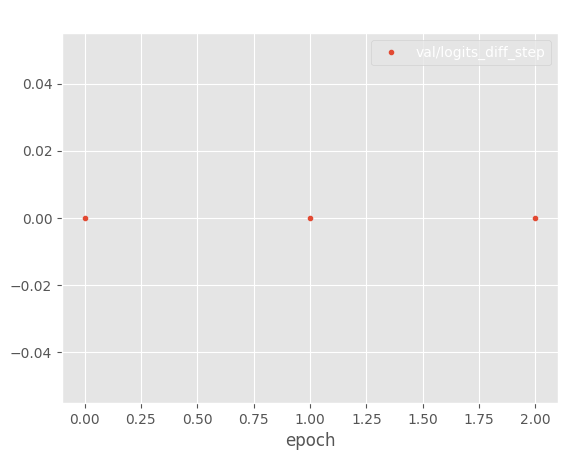

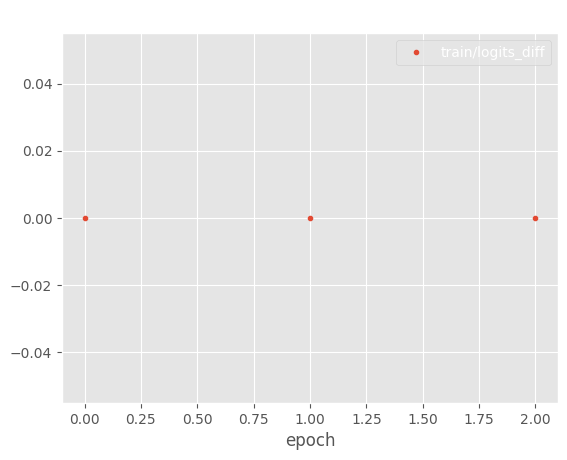

,train/loss_step,train/logits_diff,step,val/logits_diff_step,val/loss_step
total_step,,,,,
0,4.896811,0.0,0,NaN,NaN
1,5.347265,0.0,1,NaN,NaN
2,4.101336,0.0,2,NaN,NaN
3,3.191111,0.0,3,NaN,NaN
4,5.748701,0.0,4,NaN,NaN
...,...,...,...,...,...
1882,NaN,NaN,1500,0.0,1.654395
1883,NaN,NaN,1501,0.0,1.149020
1884,NaN,NaN,1502,0.0,1.854573


In [24]:
from src.helpers.lightning import read_metrics_csv, plot_hist

df_histe, df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path)
# df_hist[["train/loss_step", "val/loss_step"]].plot(style=".")
plot_hist(df_hist)
plot_hist(df_histe)
df_hist


## Generate

This acts a QC to check of the trained adapter is still coherent while giving the opposite answer


In [25]:
from src.eval.gen import gen


In [26]:

# We need to reload it from checkpoint, since lightning seems to bug it after running
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    trust_remote_code=True,
    dtype=torch.float16,  # bfloat can't be pickled
    # model_class=PhiForCausalLMWHS,
    bnb=False,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
model.eval()
model.half()
;


''

In [28]:
# Chose a row where we will see the difference

from src.eval.ds import ds2df
df_tokens = ds2df(ds_tokens).reset_index()
mask = (
    (df_tokens['instructed_to_lie']==True) &
    (df_tokens['label_true']==False)
)
bis = df_tokens[mask].index


# # mask = (
# #     (ds_tokens['instructed_to_lie']==True) &
# #     (ds_tokens['label_true']==False)
# # ).float()
bi = int(np.random.choice(bis))
bi
# # TODO doesn't work if the model gets it wrong
inputs = ds_tokens.with_format("torch")[bi]
df_tokens.iloc[bi]




index                                                             1674
ds_string                                                         hans
example_i                                                          360
answer                                                             Yes
template_name                                          does this imply
label_true                                                       False
label_instructed                                                  True
instructed_to_lie                                                 True
sys_instr_name                                                    none
question             \n\nSystem:\n.\n\nInstruct:\nThe secretary con...
truncated                                                        False
length                                                             124
prompt_truncated     <|endoftext|><|endoftext|><|endoftext|><|endof...
Name: 1674, dtype: object

In [29]:
with model.disable_adapter():
    gen(model, inputs, tokenizer)

gen(model, inputs, tokenizer)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


# Test

In [28]:
from src.eval.labels import ds2label_model_obey, ds2label_model_truth


In [29]:
TEST_BATCH_MULT = 3


In [30]:
dm2 = DeceptionDataModule(ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT)
dl_train2 = dm2.train_dataloader()
dl_train2.shuffle = False

dl_val2 = dm2.val_dataloader()
dl_test2 = dm2.test_dataloader()

dl_valtest2 = DataLoader(
    torch.utils.data.ConcatDataset([dm.datasets["val"], dm.datasets["test"]]),
    batch_size=cfg.batch_size * TEST_BATCH_MULT,
)
len(dl_valtest2.dataset)


1003

In [31]:
dl_OOD = DataLoader(
    ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT, drop_last=False, shuffle=False
)
len(dl_OOD.dataset)


1002

In [34]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    trust_remote_code=True,
    dtype=torch.float16,  # bfloat can't be pickled
    # model_class=PhiForCausalLMWHS,
)
net = model_cls(model, tokenizer)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
from src.helpers.lightning import rename_pl_test_results

rs1 = trainer.test(
    net,
    dataloaders=[
        dl_train2,
        dl_val2,
        dl_test2,
        dl_OOD,
    ],
    verbose=False
)
rs = rename_pl_test_results(rs1, ["train", "val", "test", "OOD"])
df_testing = pd.DataFrame(rs)
df_testing


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

,train,val,test,OOD
loss_epoch,1.490116,1.472688,1.498272,1.487811
n,501.000000,250.000000,251.000000,1002.000000
logits_diff_epoch,0.000000,0.000000,0.000000,0.000000


# Predict

Here we want to see if we can do a probe on the hidden states to see if it's lying...


### Collect

- see how acc each was for instructions vs truth
- see how a linear probe trained on the diff can do for truth, vs baseline

In [33]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    trust_remote_code=True,
    dtype=torch.float16,  # bfloat can't be pickled
    # model_class=PhiForCausalLMWHS,
    bnb=False,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
from src.eval.collect import manual_collect2
from src.eval.ds import filter_ds_to_known
from src.eval.labels import LABEL_MAPPING
from src.eval.ds import qc_ds, ds2df, qc_dsdf
from src.helpers.torch_helpers import batch_to_device


In [35]:
# # for single process DEBUGING
# from src.eval.collect import generate_batches
# o = next(iter(generate_batches(dl_OOD, model)))


In [36]:
# # HACK: delete
# checkpoint_path = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_1/checkpoint_last'
# trainer = pl.Trainer(
# )


In [37]:
dataset_dir=Path(trainer.log_dir)/'hidden_states'
ds_out_OOD, f = manual_collect2(dl_OOD, model, dataset_name="OOD", layers=collection_layers, dataset_dir=dataset_dir)
ds_out_valtest, f = manual_collect2(dl_valtest2, model, dataset_name="valtest", layers=collection_layers, dataset_dir=dataset_dir)


2024-01-01 07:36:44.208 | INFO     | src.eval.collect:manual_collect2:63 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/hidden_states/.ds/ds_OOD_e52cbd9274aede8b
2024-01-01T07:36:44.208830+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/hidden_states/.ds/ds_OOD_e52cbd9274aede8b


collecting hidden states:   0%|          | 0/334 [00:00<?, ?it/s]

2024-01-01 08:09:44.186 | INFO     | src.eval.collect:manual_collect2:63 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/hidden_states/.ds/ds_valtest_228c8c7509d7d7d2
2024-01-01T08:09:44.186687+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/hidden_states/.ds/ds_valtest_228c8c7509d7d7d2


collecting hidden states:   0%|          | 0/335 [00:00<?, ?it/s]

#### QC ds

In [38]:
def make_dfres2_pretty(styler):
    styler.set_caption("Dataset metrics")
    styler.background_gradient(axis=1, vmin=0, vmax=1, cmap="RdYlGn", 
                               subset=['auroc', 'lie_auroc', 'known_lie_auroc', 'choice_cov']
                               )
    styler.background_gradient(axis=1, vmin=0, vmax=0.5, cmap="RdYlGn", 
                               subset=['balance']
                               )
    return styler


In [39]:
df1 = ds2df(ds_out_valtest)
df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
res_b = qc_dsdf(df_b)
df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
res_a = qc_dsdf(df_a)
df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
print("🥉 secondary metric: dataset quality: performance of base model and adapter")
display(df_res_ab.style.pipe(make_dfres2_pretty))


🥉 secondary metric: dataset quality: performance of base model and adapter


,balance,N,auroc,lie_auroc,known_lie_auroc,choice_cov
base,0.521436,1003,0.735222,0.265017,0.266667,0.869962
adapter,0.521436,1003,0.671816,0.401351,0.390476,0.960292


In [40]:
df1 = ds2df(ds_out_OOD)
df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
res_b = qc_dsdf(df_b)
df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
res_a = qc_dsdf(df_a)
df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
print("🥉 secondary metric: dataset quality: performance of base model and adapter")
display(df_res_ab.style.pipe(make_dfres2_pretty))


🥉 secondary metric: dataset quality: performance of base model and adapter


,balance,N,auroc,lie_auroc,known_lie_auroc,choice_cov
base,0.496008,1002,0.806700,0.200546,0.148323,0.909908
adapter,0.496008,1002,0.739501,0.282753,0.231442,0.978788


### Eval

In [ ]:
# FIXME: code from 10_compare probes
from src.eval.interventions import test_intervention_quality2


In [ ]:
# def test_intervention_quality2(ds_known, label_fn, title="", skip=0, stride=1, model_kwargs={}):





In [ ]:


def analyse_intervention(ds_out, cfg, model_kwargs={}):
    ds_known = filter_ds_to_known(ds_out, verbose=True)

    print(
        f"🥇 primary metric: predictive power (of logistic regression on top of intervened hidden states of known question)"
    )
    print(
        f"""
    The roc_auc should go up on the right given the intervented states
    """
    )
    for label_name, label_fn in LABEL_MAPPING.items():
        try:
            # fit probe
            # print('='*80)
            # print(f"predicting label={label_name}")
            df_res = test_intervention_quality2(ds_known, label_fn, title=f"predicting label={label_name}",
                                                skip=cfg.skip_layers, stride=cfg.stride_layers, model_kwargs=model_kwargs)
            display(df_res)
        except Exception as e:
            raise
            print(f"Exception {e}")

    # df1 = ds2df(ds_out)
    # df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
    # res_b = qc_dsdf(df_b)
    # df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
    # res_a = qc_dsdf(df_a)
    # df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
    # print("🥉 secondary metric: dataset quality: performance of base model and adapter")
    # display(df_res_ab.style.pipe(make_dfres2_pretty))
    # return df_res_ab, df_res

# analyse_intervention(ds_out_OOD, tokenizer)



In [ ]:
print("valtest")
df_res_ab_v, df_res_v = analyse_intervention(ds_out_valtest, cfg)

print("out of distribution")
df_res_ab_o, df_res_o = analyse_intervention(ds_out_OOD, cfg)


Hypothesis: Probes on adapter are better than either probes or adapters.

|model| val acc | OOD acc |
|--|--|--|
|base model  acc | 0.64  | 0.69 OOD |
|adapter acc | 0.65  | 0.65 |
|base+probe model residual auroc | 0.89 | 0.917|
|adapter+probe residual auroc | **0.905** | **0.974** |

So yes! Hypothesis confirmed
mm


# plot labels vs each other

to try and see why ranking is better
